# Color frequency map

As I'm trying to figure out the best ways to reduce the number of colors in an image, I've been looking at what's a common color and what is not, a kind of image statistics. What seems like pretty much the same color is often a whole range of slightly different values. So I tried to write a fuction that would return a "frequency map", showing the areas where the pixels in the original image have colors of high or low frequencies.

It is all done on NumPy arrays, image is first imported using the skimage io module:

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from skimage import io


The idea is the following: we need a table of all the pixels in the image, with their red, green and blue values, and also the number of times such combination of r, g and b values occurs in the original image. Then we can map these frequencies to 0-255 values, so that the lowest frequency corresponds to a zero and the highest to 255, and create a frequency map by assigning those new values to the pixels.


In [26]:
def freqmap(image):
    
    '''converts an image into a frequency map where the pixels get a color proportional to the frequency of their original color
    in the original image: pixels with a color with the highest count become white, those with the lowest count are black
    e.g an image with just one single color will become all white, meanwhile a random noise will become mostly black
    '''
    
    image_res = image.reshape(-1,3, order = 'F')
    # convert the image into to a 2D array, shape is (vres*hres*channels); important: 'F' order
    
    (colors, idx, counts) = np.unique(image_res, axis = 0, return_counts = True, return_inverse = True) 
    # get colors, index of color counts, and counts
       
    freqs = counts[idx[:]]
    # gets the counts by their index, creating a 1D array 
    
    a = 255/(np.max(counts) - np.min(counts))
    #calculate a in ax+b: a = (y2 - y1)/(x2-x1)
    
    b = - a*np.min(counts)
    #calculate b in ax+b: b = y1-a*x1
        
    freqs_conv = a*freqs + b
    #creates a 1D array of scaled values, where the highest color count corresponds to 255 and the lowest to 0                     
        
    freqmap = freqs_conv.reshape(image.shape[0], image.shape[1], order = 'F')
    #reshapes the array from above into a 2D array shaped like the original image
    
    freqmap = np.clip(freqmap, 0,255).astype('uint8')
    # clips the values below 0 and above 255, and makes them all unsigned 8bit integers
    
                
    return freqmap
                             
    


Let's test it on a very noisy image:


In [4]:
hd_noise = np.random.randint(0,256,size = (1080,1920,3), dtype = ('uint8'))

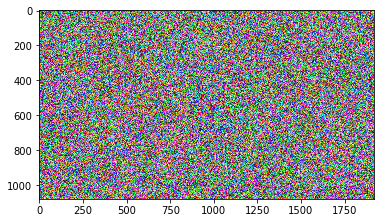

In [5]:
plt.imshow(hd_noise)

In [6]:
%timeit freqmap(hd_noise)

1.93 s ± 62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



It takes a while, the longest part is getting the counts and the index from the np.unique function.


In [7]:
hd_noise_fq = freqmap(hd_noise)

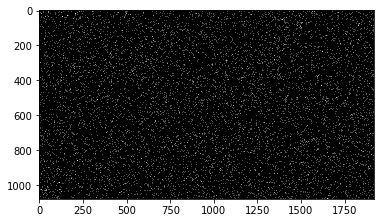

In [8]:
plt.imshow(hd_noise_fq, cmap = 'Greys_r')


As expected, it's mostly black (pixels with a color that occurs only once in the whole image).



Using the matplotlib we can apply various colormaps to the single channel image we obtained, but it could be done right there in the function itself. Here we are using a gradient from pure yellow (255,255,0) for the highest frequencies to pure blue (0,0,255) for the lowest: 


In [9]:
def freqmap_gradient(image):
    
    '''converts an image into a frequency map where the pixels get a color proportional to the frequency of their original color
    in the original image: pixels with a color with the highest count become yellow, those with the lowest count are blue
    '''
    image_res = image.reshape(-1,3, order = 'F') 
        
    (colors, idx, counts) = np.unique(image_res, axis = 0, return_counts = True, return_inverse = True)
           
    freqs = counts[idx[:]]
    
    a = 255/(np.max(counts) - np.min(counts))
    b = -a*np.min(counts)
        
    freqs_conv = a*freqs + b
    
    channel = freqs_conv.reshape(image.shape[0], image.shape[1], order = 'F')
    inv_channel = -(channel-255) # 0s become 255s and 255 become 0s
        
    freqmap = np.stack([channel,channel,inv_channel], axis = 2)
    #stacks the three channels together
    
    freqmap = np.clip(freqmap, 0,255).astype('uint8')
                     
    return freqmap

In [10]:
%timeit freqmap_gradient(hd_noise)

2.1 s ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



Inverting the values of a channel and then stacking the three channels together adds about 200 ms. It may not sound like a lot, but if we were to batch process ten thousands Full HD images, it would be over a half an hour more, for something that is not really necessary in this case. 


In [3]:
helsinki = io.imread('helsinki_a520_IMG_3625.JPG')

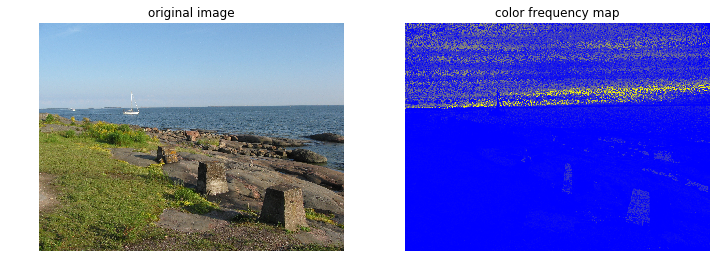

In [12]:
fig = plt.figure(figsize=(12,16))

image1 = plt.subplot(121)
image2 = plt.subplot(122)

_ = image1.imshow(helsinki)
_ = image2.imshow(freqmap_gradient(helsinki))

image1.axis('off')
image1.set_title('original image')
image2.axis('off')
image2.set_title('color frequency map')

plt.show()


It seems like the only bigger areas of same color pixels are in the skies, meanwhile pretty much everything else is made of low frequency colors.

Just a test to see if everything goes as expected, using a simple image with just some colors that I just created with GIMP:


In [20]:
freqtest1 = io.imread('freqtest1.jpg')

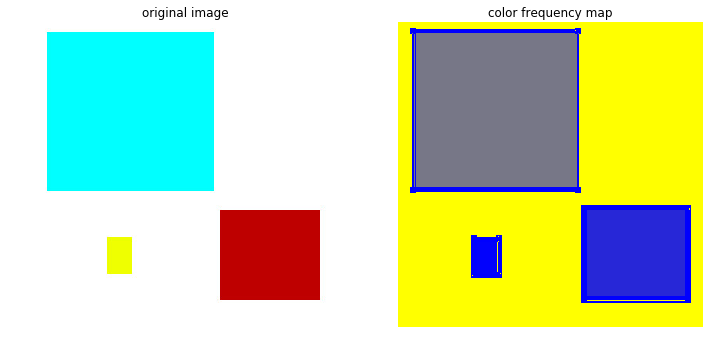

In [23]:
fig = plt.figure(figsize=(12,16))

image1 = plt.subplot(121)
image2 = plt.subplot(122)

_ = image1.imshow(freqtest1)
_ = image2.imshow(freqmap_gradient(freqtest1))

image1.axis('off')
image1.set_title('original image')
image2.axis('off')
image2.set_title('color frequency map')

plt.show()


Wait, what's that? I was expecting four colors in total, but it seems like there is something strange going on on the edges of the rectangles. I couldn't figure it out for a while, as in GIMP everything seemed OK... but then I realized that it must have had something to do with how the JPG file is saved. GIMP's default JPG quality is 90, so let's see what happens if I crank it up to 100:


In [25]:
freqtest2 = io.imread('freqtest2.jpg')

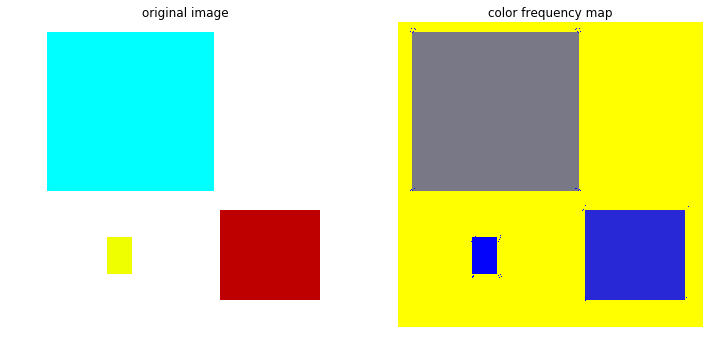

In [26]:
fig = plt.figure(figsize=(12,16))

image1 = plt.subplot(121)
image2 = plt.subplot(122)

_ = image1.imshow(freqtest2)
_ = image2.imshow(freqmap_gradient(freqtest2))

image1.axis('off')
image1.set_title('original image')
image2.axis('off')
image2.set_title('color frequency map')

plt.show()


That was it: artifacts from JPG compression. Even at 100 quality you can still see some stray pixels here and there. But the main thing is: it works. The smallest rectangle (lowest count) is pure blue, the biggest one is grey, halfway through the gradient, and the background is yellow. Once again in shades of gray:


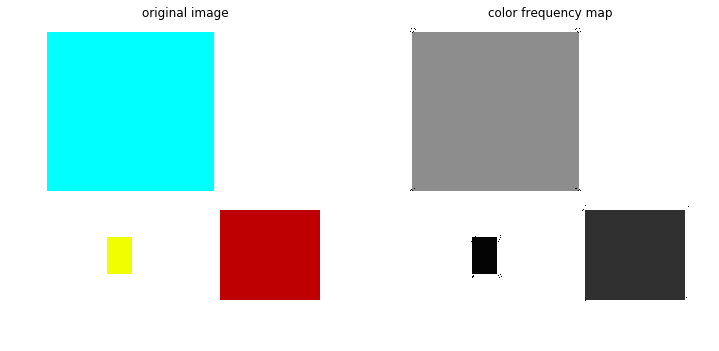

In [27]:
fig = plt.figure(figsize=(12,16))

image1 = plt.subplot(121)
image2 = plt.subplot(122)

_ = image1.imshow(freqtest2)
_ = image2.imshow(freqmap(freqtest2), cmap = 'Greys_r')

image1.axis('off')
image1.set_title('original image')
image2.axis('off')
image2.set_title('color frequency map')

plt.show()


It works! This frequency map could also be used as a mask for some other operations on the original image, but the main thing is that I figured out how to count the colors in pure NumPy. Stay tuned for some more tinkering with digital images!



Let's try and see what happens if we multiply the values of the original image by the frequency map, normalized to 0 - 1 values:


In [133]:
def freqmask(image, inv = False):
    
    '''converts an image into a frequency map where the pixels get a color proportional to the frequency of their original color
    in the original image: pixels with a color with the highest count become white, those with the lowest count are black
    e.g an image with just one single color will become all white, meanwhile a random noise will become mostly black
    '''
    
    image_res = image.reshape(-1,3, order = 'F')
        
    (colors, idx, counts) = np.unique(image_res, axis = 0, return_counts = True, return_inverse = True) 
           
    freqs = counts[idx[:]]
        
    a = 255/(np.max(counts) - np.min(counts))
        
    b = - a*np.min(counts)
            
    freqs_conv = a*freqs + b
            
    freqmap = freqs_conv.reshape(image.shape[0], image.shape[1], order = 'F')
      
    
    if inv == True:
        freqmap = -(freqmap-255)
    # inverts the values, i.e. 0 becomes 255 and 255 becomes 0
    
    freqmask = freqmap/255
    # normalized to 0.0-1.0 values
    
    freqmask3D = np.stack([freqmask, freqmask, freqmask], axis = 2)
       
    image_fq = image * freqmask3D
    
    image_fq = np.clip(image_fq, 0,255).astype('uint8')
    
    return image_fq
                           

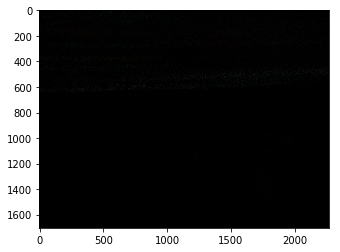

In [134]:
plt.imshow(freqmask(helsinki))


It's really dark! Only the values with highest frequencies remain, everything else gets almost zeroed to black. Let's see what happens if we use the inverted proportion:


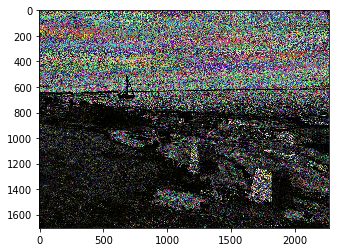

In [135]:
plt.imshow(freqmask(helsinki, inv = True))


It's the UCSs again! Unpredicted Color Shifts. All three channels get a boost, but the results don't make much sense. If there only was a way to simply modify the brightness of the pixels, without worrying about how it affects the three color components... and there is!


In [58]:
from skimage import color


We can use the HSV color system, so that we can control the V like value (whether the color is dark or bright), or S like saturation. What we need to do is to convert the original RGB color to HSV, then multiply either the S or V bitplane by the frequency mask, and then convert back to RGB. 


In [136]:
def freqmask2(image, n, inv=False):
    
    '''converts an image into a frequency map where each pixel's saturation (n=1) or value (n=2) is set in proportion
    to the frequency of their original color in the original image. Inv parameter defines whether the values are directly 
    or inversely proportional'''
    
    image_res = image.reshape(-1,3, order = 'F')
        
    (colors, idx, counts) = np.unique(image_res, axis = 0, return_counts = True, return_inverse = True) 
           
    freqs = counts[idx[:]]
        
    a = 255/(np.max(counts) - np.min(counts))
        
    b = - a*np.min(counts)
            
    freqs_conv = a*freqs + b
            
    freqmap = freqs_conv.reshape(image.shape[0], image.shape[1], order = 'F')
      
    if inv == True:
        freqmap = -(freqmap-255)
    
    freqmask = freqmap/255
        
    image_hsv = color.rgb2hsv(image)
    
    image_hsv[:,:,n] = image_hsv[:,:,n] * freqmask
     
    image_fq = color.hsv2rgb(image_hsv) * 255 #conversion is back to 0.0-1.0 range
    
    image_fq = np.clip(image_fq,0,255).astype('uint8')
    
    return image_fq

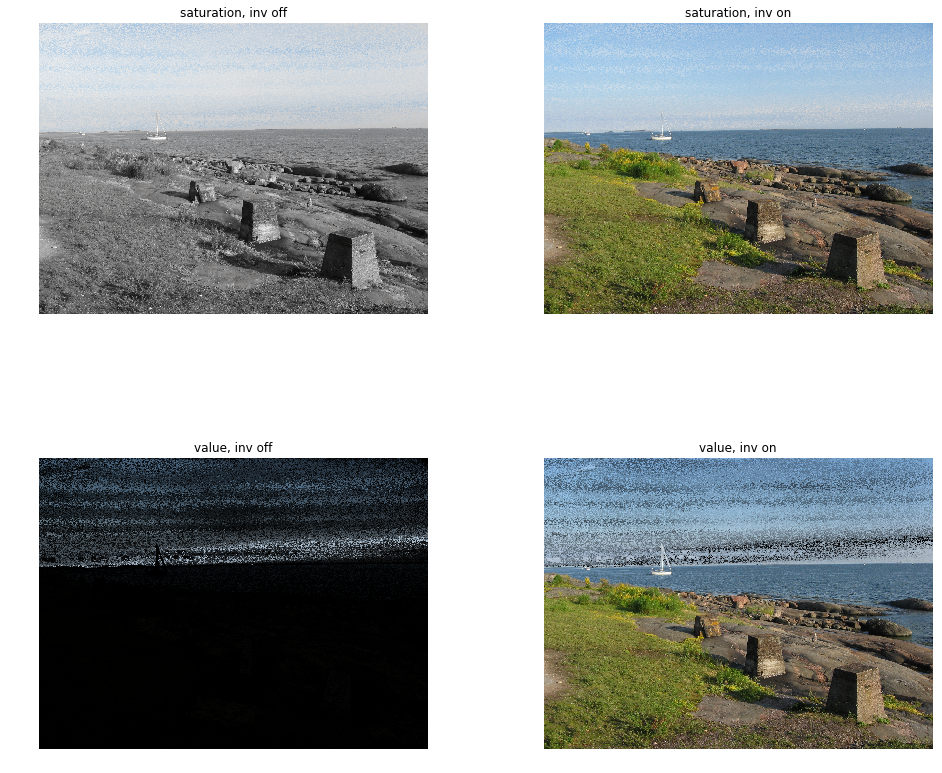

In [149]:
fig = plt.figure(figsize = (16,16))
fig.subplots_adjust(hspace=0, wspace=0.3)
   
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(freqmask2(helsinki, 1))
ax1.axis('off')
plt.title('saturation, inv off')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(freqmask2(helsinki, 1, inv = True))
ax2.axis('off')
plt.title('saturation, inv on')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(freqmask2(helsinki, 2))  
ax3.axis('off')
plt.title('value, inv off')
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(freqmask2(helsinki, 2, inv = True))
ax4.axis('off')
plt.title('value, inv on')

plt.show()


This time it works as expected: low/high frequency areas get desaturated or darkened, as specified by function's parameters.

When skimage converts from RGB to HSV, all three channels take values from 0.0 to 1.0. It means that we can put n=0 in the above function, to see how the frequency mask modifies the hue of the original image... now that's Unpredicted Color Shifts!


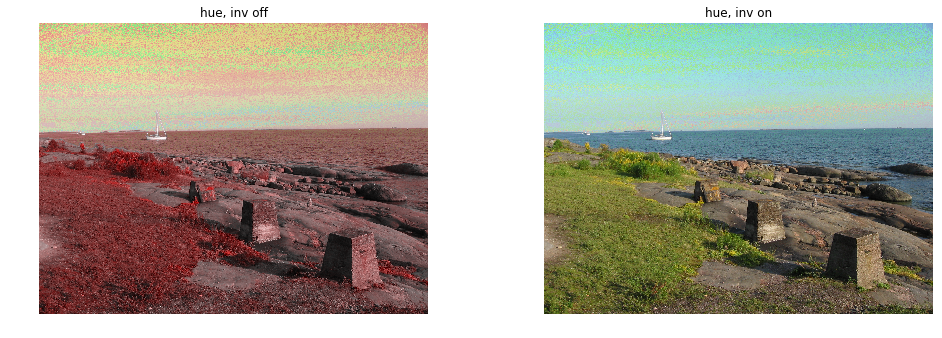

In [150]:
fig = plt.figure(figsize = (16,8))
fig.subplots_adjust(hspace=0, wspace=0.3)
   
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(freqmask2(helsinki, 0))
ax1.axis('off')
plt.title('hue, inv off')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(freqmask2(helsinki, 0, inv = True))
ax2.axis('off')
plt.title('hue, inv on')

plt.show()


Feel free to use this for some creative manipulation of your own photos! :) 
